In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv(r'data/train.csv')
test_data = pd.read_csv(r'data/test.csv')
gender_submission = pd.read_csv(r'data/gender_submission.csv')

In [3]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}") #doesn't have y_class

Train dataset shape: (891, 12)
Test dataset shape: (418, 11)


In [4]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_data['Pclass'].value_counts()


3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
train_data['Sex'].value_counts()


male      577
female    314
Name: Sex, dtype: int64

In [10]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

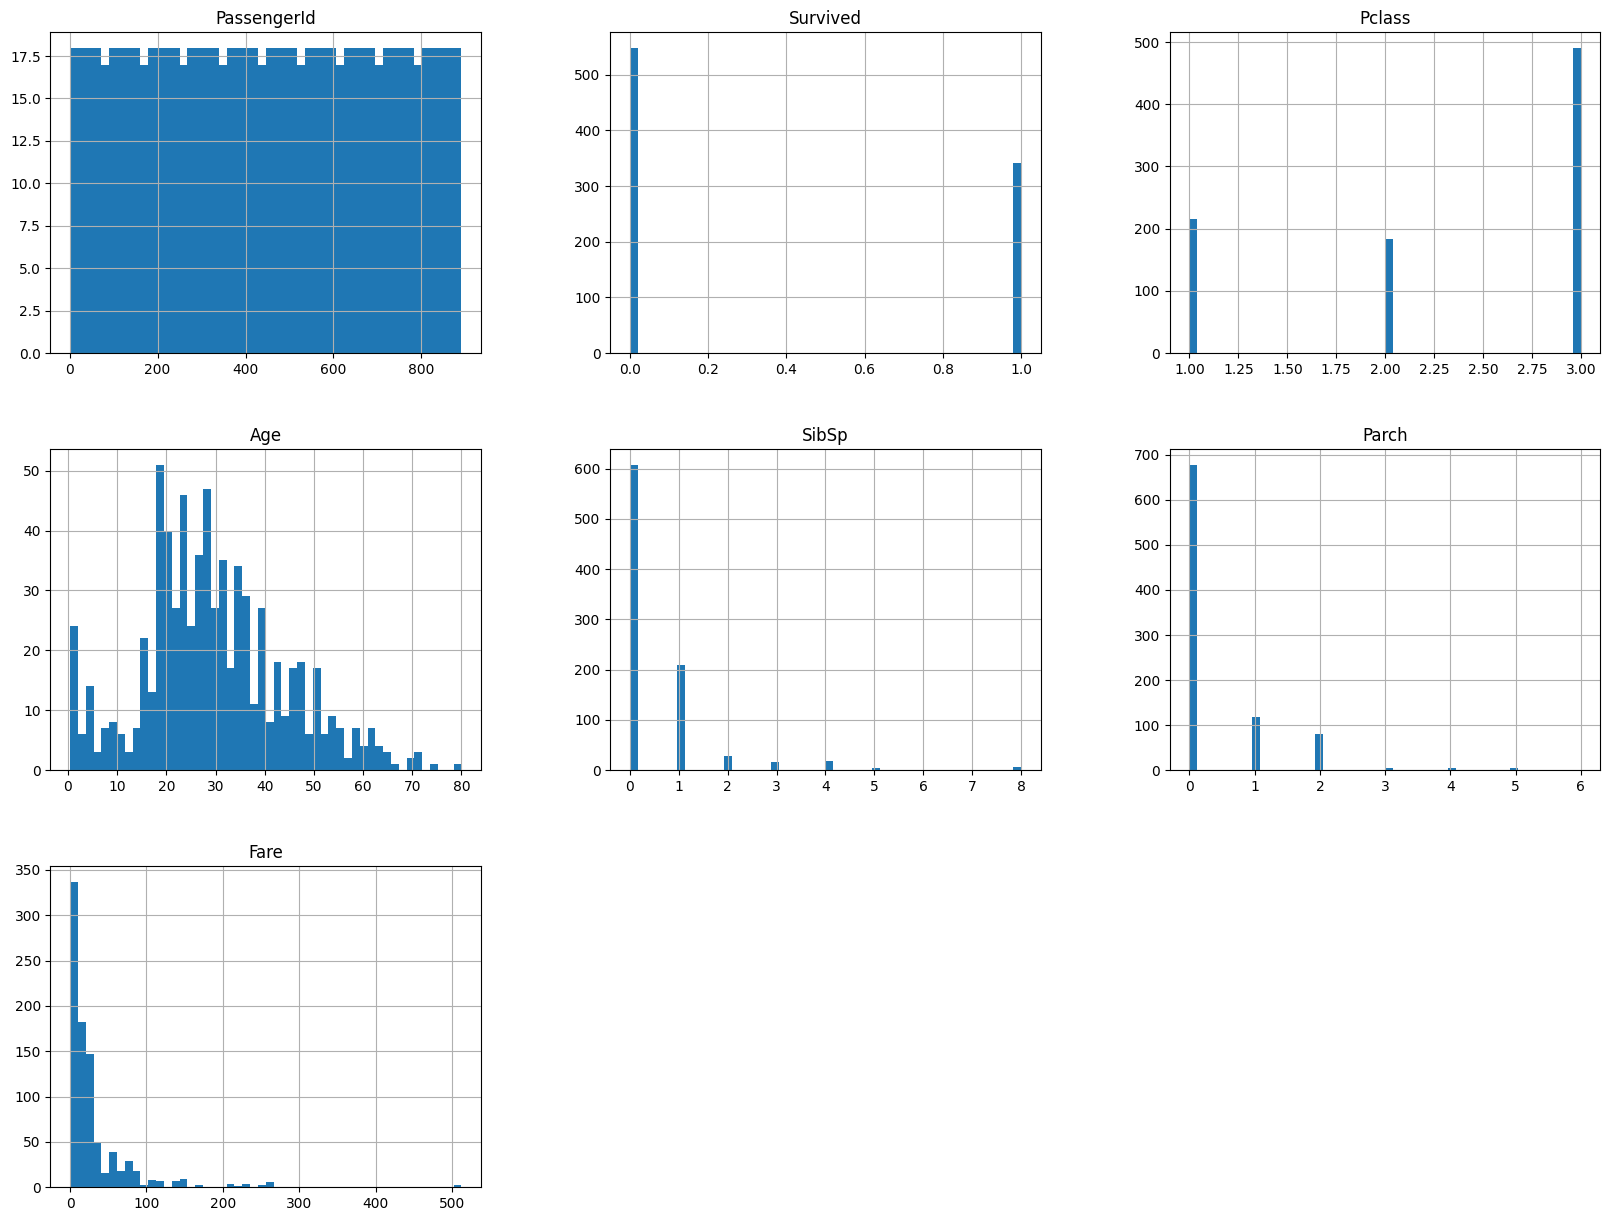

In [11]:
train_data.hist(bins = 50, figsize=(20,15))
plt.show()

In [12]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

array([[<AxesSubplot: xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot: xlabel='Fare', ylabel='Survived'>,
        <AxesSubplot: xlabel='Parch', ylabel='Survived'>,
        <AxesSubplot: xlabel='SibSp', ylabel='Survived'>,
        <AxesSubplot: xlabel='Age', ylabel='Survived'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Survived'>],
       [<AxesSubplot: xlabel='Survived', ylabel='Fare'>,
        <AxesSubplot: xlabel='Fare', ylabel='Fare'>,
        <AxesSubplot: xlabel='Parch', ylabel='Fare'>,
        <AxesSubplot: xlabel='SibSp', ylabel='Fare'>,
        <AxesSubplot: xlabel='Age', ylabel='Fare'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Fare'>],
       [<AxesSubplot: xlabel='Survived', ylabel='Parch'>,
        <AxesSubplot: xlabel='Fare', ylabel='Parch'>,
        <AxesSubplot: xlabel='Parch', ylabel='Parch'>,
        <AxesSubplot: xlabel='SibSp', ylabel='Parch'>,
        <AxesSubplot: xlabel='Age', ylabel='Parch'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Pa

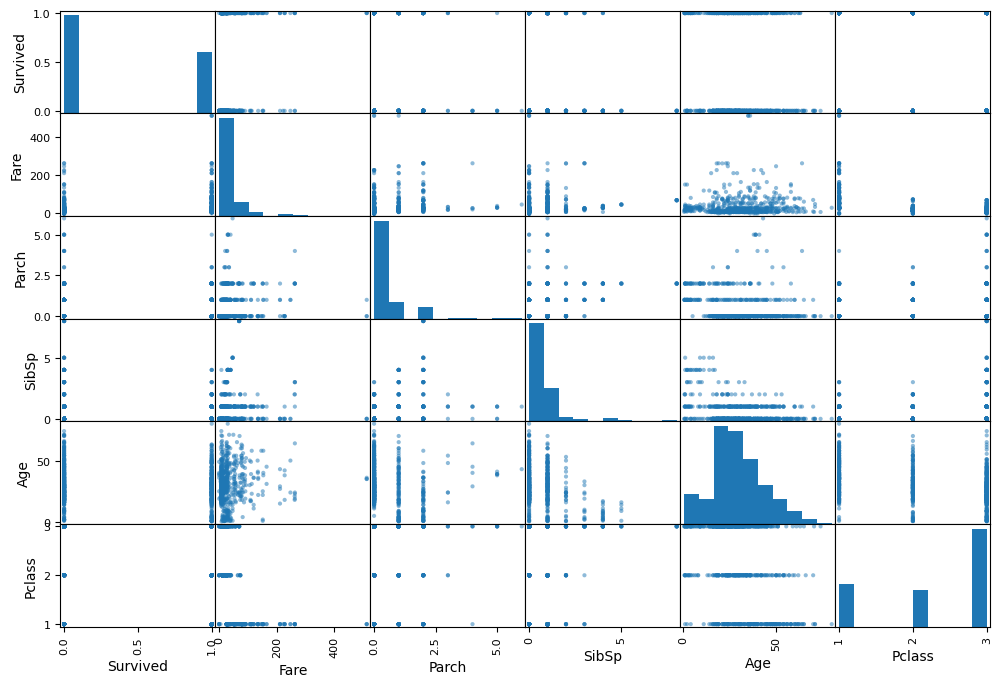

In [13]:
attributes = ["Survived", "Fare", "Parch", "SibSp", "Age", "Pclass"]
pd.plotting.scatter_matrix(train_data[attributes], figsize=(12,8))

In [14]:
choosen_data_to_train = train_data[[
            "Survived",
            "Pclass",
            "Sex",
            "Age",
            "SibSp",
            "Parch",
            "Fare",
            "Embarked",
]]
choosen_data_to_train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [15]:
choosen_data_to_train['_sum_of_family_members'] = choosen_data_to_train["SibSp"] + choosen_data_to_train["Parch"]
choosen_data_to_train['_aproximetely_sum_of_family_members_fare'] = choosen_data_to_train["Fare"] * (choosen_data_to_train["_sum_of_family_members"]+1)
corr_matrix = choosen_data_to_train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived                                    1.000000
Fare                                        0.257307
_aproximetely_sum_of_family_members_fare    0.127689
Parch                                       0.081629
_sum_of_family_members                      0.016639
SibSp                                      -0.035322
Age                                        -0.077221
Pclass                                     -0.338481
Name: Survived, dtype: float64

In [16]:
choosen_data_to_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Survived                                  891 non-null    int64  
 1   Pclass                                    891 non-null    int64  
 2   Sex                                       891 non-null    object 
 3   Age                                       714 non-null    float64
 4   SibSp                                     891 non-null    int64  
 5   Parch                                     891 non-null    int64  
 6   Fare                                      891 non-null    float64
 7   Embarked                                  889 non-null    object 
 8   _sum_of_family_members                    891 non-null    int64  
 9   _aproximetely_sum_of_family_members_fare  891 non-null    float64
dtypes: float64(3), int64(5), object(2)
mem

In [17]:
X_train = choosen_data_to_train.drop("Survived", axis=1)
Y_train = choosen_data_to_train["Survived"].copy()

In [18]:
num_features = list(X_train.drop(["Sex", "Embarked"], axis=1).columns)
cat_features = ["Sex", "Embarked"]

In [19]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

In [20]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("one_hot_encoder", OneHotEncoder()),
])

In [21]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])
X_train_prepared = full_pipeline.fit_transform(X_train)

In [22]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train_prepared, Y_train, cv=10)

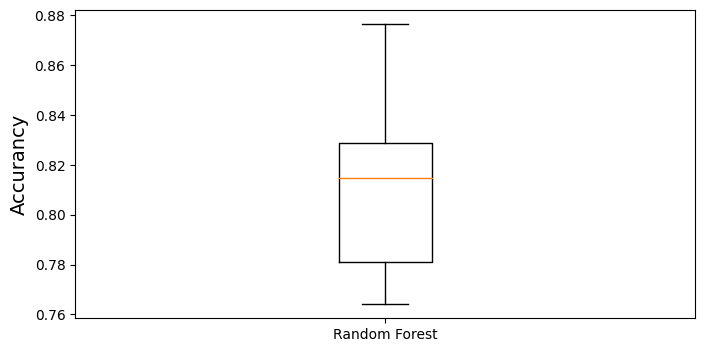

In [23]:
plt.figure(figsize=(8, 4))
# plt.plot([1]*10,forest_scores, ".")
plt.boxplot(forest_scores, labels=["Random Forest"])
plt.ylabel("Accurancy", fontsize=14)
plt.show()

In [24]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train_prepared, Y_train, cv=3)
print(f"Model is not wrong at {round(precision_score(Y_train,y_train_pred_forest)*100,2)}% |PRECISION")
print(f"Model recognize {round(recall_score(Y_train,y_train_pred_forest)*100,2)}% of target |RECALL")

Model is not wrong at 73.35% |PRECISION
Model recognize 71.64% of target |RECALL


In [25]:
hyperparameters = {
        'n_estimators': [90, 100, 115, 130],
        'max_depth': range(2,20,1),
        'min_samples_leaf': range(1,10,1),
        'min_samples_split': range(2,10,1),
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'log2'],
    }

forest_clf = RandomForestClassifier(random_state=42)
ranodm_search = RandomizedSearchCV(forest_clf, param_distributions=hyperparameters,
                                n_iter=10, cv=5, random_state=42, verbose=2)
ranodm_search.fit(X_train_prepared, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=130; total time=   0.5s
[CV] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=130; total time=   0.7s
[CV] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=130; total time=   0.3s
[CV] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=130; total time=   0.4s
[CV] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=130; total time=   0.3s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=9, min_samples_split=9, n_estimators=90; total time=   0.2s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=9, min_samples_split=9, n_estimators

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 20),
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': [90, 100, 115, 130]},
                   random_state=42, verbose=2)

In [26]:
ranodm_search.best_params_

{'n_estimators': 130,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 9,
 'criterion': 'entropy'}

In [27]:
forest_clf = RandomForestClassifier(n_estimators= 130,
                    min_samples_split= 7,
                    min_samples_leaf= 1,
                    max_features= 'auto',
                    max_depth= 9,
                    criterion= 'entropy',
                    random_state=42)
forest_clf.fit(X_train_prepared, Y_train)
forest_scores = cross_val_score(forest_clf, X_train_prepared, Y_train, cv=10)

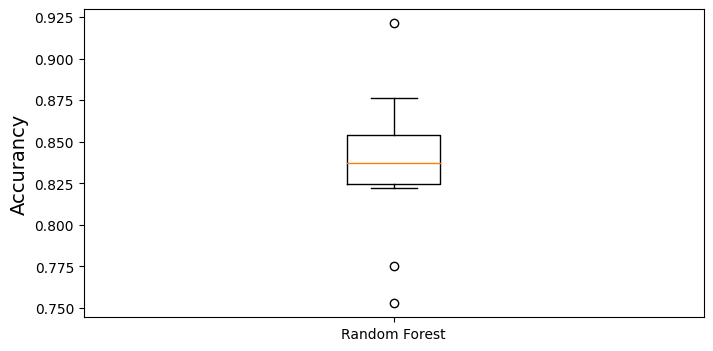

In [28]:
plt.figure(figsize=(8, 4))
# plt.plot([1]*10,forest_scores, ".")
plt.boxplot(forest_scores, labels=["Random Forest"])
plt.ylabel("Accurancy", fontsize=14)
plt.show()

In [29]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train_prepared, Y_train, cv=3)
print(f"Model is not wrong at {round(precision_score(Y_train,y_train_pred_forest)*100,2)}% |PRECISION")
print(f"Model recognize {round(recall_score(Y_train,y_train_pred_forest)*100,2)}% of target |RECALL")

Model is not wrong at 81.23% |PRECISION
Model recognize 73.39% of target |RECALL


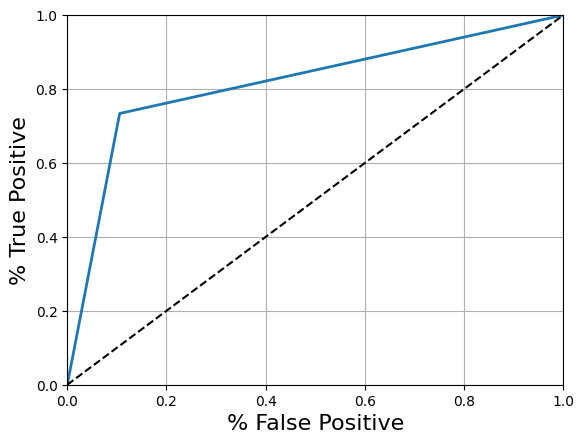

In [30]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_train,y_train_pred_forest)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                       
    plt.xlabel('% False Positive', fontsize=16)     
    plt.ylabel('% True Positive', fontsize=16)    
    plt.grid(True)                                               
plot_roc_curve(fpr_forest, tpr_forest)

In [31]:
print(f"AUC score = {roc_auc_score(Y_train,y_train_pred_forest)}") 

AUC score = 0.8141357492090883


In [32]:
conf_mx = confusion_matrix(Y_train,y_train_pred_forest)
conf_mx

array([[491,  58],
       [ 91, 251]], dtype=int64)

In [33]:
# this should be done in different way ----> definetely I should add it to pipeline
choosen_data = test_data[[
            "Pclass",
            "Sex",
            "Age",
            "SibSp",
            "Parch",
            "Fare",
            "Embarked",
]]
choosen_data['_sum_of_family_members'] = choosen_data["SibSp"] + choosen_data["Parch"]
choosen_data['_aproximetely_sum_of_family_members_fare'] = choosen_data["Fare"] * (choosen_data["_sum_of_family_members"]+1)
X_test_prepared = full_pipeline.transform(choosen_data)

In [39]:
test_predicted = forest_clf.predict(X_test_prepared)

In [46]:
output = pd.DataFrame({'PassengerId':test_data.PassengerId, 'Survived':test_predicted.astype(int)}) 
output.to_csv(r'data/output.csv', index=False) #for now kaggle returns ~77% accurancy --> in the future I will work more at this dataset
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
